In [32]:
import pandas as pd
import numpy as np
from numpy import ndarray
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from matplotlib import pyplot as plt
from feature_selector import FeatureSelector

In [33]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('./data/TUANDROMD.csv')

In [34]:
print('Total number of rows:', df.shape[0])
df.head(5)

Total number of rows: 4464


,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,ACCESS_PROVIDER,ACCESS_SERVICE,ACCESS_SHARED_DATA,ACCESS_SUPERUSER,ACCESS_SURFACE_FLINGER,ACCESS_WIFI_STATE,activityCalled,ACTIVITY_RECOGNITION,ACCOUNT_MANAGER,ADD_VOICEMAIL,ANT,ANT_ADMIN,AUTHENTICATE_ACCOUNTS,AUTORUN_MANAGER_LICENSE_MANAGER,AUTORUN_MANAGER_LICENSE_SERVICE(.autorun),BATTERY_STATS,BILLING,BIND_ACCESSIBILITY_SERVICE,BIND_APPWIDGET,BIND_CARRIER_MESSAGING_SERVICE,BIND_DEVICE_ADMIN,BIND_DREAM_SERVICE,BIND_GET_INSTALL_REFERRER_SERVICE,BIND_INPUT_METHOD,BIND_NFC_SERVICE,BIND_goodwareTIFICATION_LISTENER_SERVICE,BIND_PRINT_SERVICE,BIND_REMOTEVIEWS,BIND_TEXT_SERVICE,BIND_TV_INPUT,BIND_VOICE_INTERACTION,BIND_VPN_SERVICE,BIND_WALLPAPER,BLUETOOTH,BLUETOOTH_ADMIN,BLUETOOTH_PRIVILEGED,BODY_SENSORS,BRICK,BROADCAST_PACKAGE_REMOVED,BROADCAST_SMS,BROADCAST_STICKY,BROADCAST_WAP_PUSH,C2D_MESSAGE,CALL_PHONE,CALL_PRIVILEGED,CAMERA,CAPTURE_AUDIO_OUTPUT,CAPTURE_SECURE_VIDEO_OUTPUT,CAPTURE_VIDEO_OUTPUT,CHANGE_COMPONENT_ENABLED_STATE,CHANGE_CONFIGURATION,CHANGE_DISPLAY_MODE,CHANGE_NETWORK_STATE,CHANGE_WIFI_MULTICAST_STATE,CHANGE_WIFI_STATE,CHECK_LICENSE,CLEAR_APP_CACHE,CLEAR_APP_USER_DATA,CONTROL_LOCATION_UPDATES,DATABASE_INTERFACE_SERVICE,DELETE_CACHE_FILES,DELETE_PACKAGES,DEVICE_POWER,DIAGgoodwareSTIC,DISABLE_KEYGUARD,DOWNLOAD_SERVICE,DOWNLOAD_WITHOUT_goodwareTIFICATION,DUMP,EXPAND_STATUS_BAR,EXTENSION_PERMISSION,FACTORY_TEST,FLASHLIGHT,FORCE_BACK,FULLSCREEN.FULL,GET_ACCOUNTS,GET_PACKAGE_SIZE,GET_TASKS,GET_TOP_ACTIVITY_INFO,GLOBAL_SEARCH,GOOGLE_AUTH,GOOGLE_PHOTOS,HARDWARE_TEST,INJECT_EVENTS,INSTALL_LOCATION_PROVIDER,INSTALL_PACKAGES,INSTALL_SHORTCUT,INTERACT_ACROSS_USERS,INTERNAL_SYSTEM_WINDOW,INTERNET,JPUSH_MESSAGE,KILL_BACKGROUND_PROCESSES,LOCATION_HARDWARE,MANAGE_ACCOUNTS,MANAGE_APP_TOKENS,MANAGE_DOCUMENTS,MAPS_RECEIVE,MASTER_CLEAR,MEDIA_BUTTON,MEDIA_CONTENT_CONTROL,MESSAGE,MODIFY_AUDIO_SETTINGS,MODIFY_PHONE_STATE,MOUNT_FORMAT_FILESYSTEMS,MOUNT_UNMOUNT_FILESYSTEMS,NFC,PERSISTENT_ACTIVITY,PERMISSION,PERMISSION_RUN_TASKS,PLUGIN,PROCESS_OUTGOING_CALLS,READ,READ_ATTACHMENT,READ_AVESTTINGS,READ_CALENDAR,READ_CALL_LOG,READ_CONTACTS,READ_CONTENT_PROVIDER,READ_DATA,READ_DATABASES,READ_EXTERNAL_STORAGE,READ_FRAME_BUFFER,READ_GMAIL,READ_GSERVICES,READ_HISTORY_BOOKMARKS,READ_INPUT_STATE,READ_LOGS,READ_MESSAGES,READ_OWNER_DATA,READ_PHONE_STATE,READ_PROFILE,READ_SETTINGS,READ_SMS,READ_SOCIAL_STREAM,READ_SYNC_SETTINGS,READ_SYNC_STATS,READ_USER_DICTIONARY,READ_VOICEMAIL,REBOOT,RECEIVE,RECEIVE_BOOT_COMPLETED,RECEIVE_MMS,RECEIVE_SIGNED_DATA_RESULT,RECEIVE_SMS,RECEIVE_USER_PRESENT,RECEIVE_WAP_PUSH,RECORD_AUDIO,REORDER_TASKS,RESPOND,RESTART_PACKAGES,REQUEST,SDCARD_WRITE,SEND,SEND_RESPOND_VIA_MESSAGE,SEND_SMS,SET_ACTIVITY_WATCHER,SET_ALARM,SET_ALWAYS_FINISH,SET_ANIMATION_SCALE,SET_DEBUG_APP,SET_ORIENTATION,SET_POINTER_SPEED,SET_PREFERRED_APPLICATIONS,SET_PROCESS_LIMIT,SET_TIME,SET_TIME_ZONE,SET_WALLPAPER,SET_WALLPAPER_HINTS,SIGNAL_PERSISTENT_PROCESSES,STATUS_BAR,STORAGE,SUBSCRIBED_FEEDS_READ,SUBSCRIBED_FEEDS_WRITE,SYSTEM_ALERT_WINDOW,TRANSMIT_IR,UNINSTALL_SHORTCUT,UPDATE_DEVICE_STATS,USES_POLICY_FORCE_LOCK,USE_CREDENTIALS,USE_FINGERPRINT,USE_SIP,VIBRATE,WAKE_LOCK,WRITE,WRITE_APN_SETTINGS,WRITE_AVSETTING,WRITE_CALENDAR,WRITE_CALL_LOG,WRITE_CONTACTS,WRITE_DATA,WRITE_DATABASES,WRITE_EXTERNAL_STORAGE,WRITE_GSERVICES,WRITE_HISTORY_BOOKMARKS,WRITE_INTERNAL_STORAGE,WRITE_MEDIA_STORAGE,WRITE_OWNER_DATA,WRITE_PROFILE,WRITE_SECURE_SETTINGS,WRITE_SETTINGS,WRITE_SMS,WRITE_SOCIAL_STREAM,WRITE_SYNC_SETTINGS,WRITE_USER_DICTIONARY,WRITE_VOICEMAIL,Ljava/lang/reflect/Method;->invoke,Ljavax/crypto/Cipher;->doFinal,Ljava/lang/Runtime;->exec,Ljava/lang/System;->load,Ldalvik/system/DexClassLoader;->loadClass,Ljava/lang/System;->loadLibrary,Ljava/net/URL;->openConnection,Landroid/hardware/Camera;->open,Landroid/hardware/Camera;->takePicture,Landroid/t

## Preprocessing

In [35]:
# Очистка данных от неинформативных признаков
df_labels = df['Label']
df_cropped = df.drop(columns = ['Label'])
fs = FeatureSelector(data = df_cropped, labels = df_labels)
fs.identify_single_unique()
single_unique = fs.ops['single_unique']
fs.identify_collinear(correlation_threshold=0.975)
collinear = fs.ops['collinear']
df_removed = df.drop(columns = single_unique + collinear)

42 features with a single unique value.

63 features with a correlation magnitude greater than 0.97.



/Users/matvey.karpov/Projects/IDA_task2/feature_selector.py:222: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)


In [36]:
def remove_outliers(x: ndarray, y: ndarray) -> tuple:
    y_pred = LocalOutlierFactor(n_neighbors=10, contamination=0.1).fit_predict(x)
    # 1 - inlier, -1 - outlier
    return x[[x == 1 for x in y_pred]], y[[x == 1 for x in y_pred]]

In [37]:
x = df_removed.values[:, :df_removed.shape[1] - 1]
y = np.array([1 if y == 'malware' else 0 for y in df_removed.values[:, df_removed.shape[1] - 1]])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)
x_train_cleaned, y_train_cleaned = remove_outliers(x_train, y_train)

## Comparing models

In [38]:
def use_model(model, x_train, y_train, x_test, y_test, calc_roc_auc=True):
    model.fit(x_train, y_train)
    print("Score on train: "+ str(model.score(x_train, y_train)))
    print("Score on test: "+ str(model.score(x_test, y_test)))
    scores = cross_val_score(model, x, y, cv=5)
    print("Cross validation got %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    prediction = model.predict(x_test)
    print(classification_report(prediction, y_test))
    if calc_roc_auc:
        probs = model.predict_proba(x_test)
        # сохраняем вероятности только для положительного исхода
        probs = probs[:, 1]
        # рассчитываем ROC AUC
        auc_score = roc_auc_score(y_test, probs)
        print('ROC AUC=%.3f' % auc_score)
        # рассчитываем roc-кривую
        fpr, tpr, treshold = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        # строим график
        plt.plot(fpr, tpr, color='red',
                 label='Площадь (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

### KNN

In [39]:
knn = KNeighborsClassifier(n_neighbors=5)

Score on train: 0.988050784167289
Score on test: 0.9882418812989922
Cross validation got 0.97 accuracy with a standard deviation of 0.03
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       358
           1       0.99      0.99      0.99      1428

    accuracy                           0.99      1786
   macro avg       0.98      0.98      0.98      1786
weighted avg       0.99      0.99      0.99      1786

ROC AUC=0.994


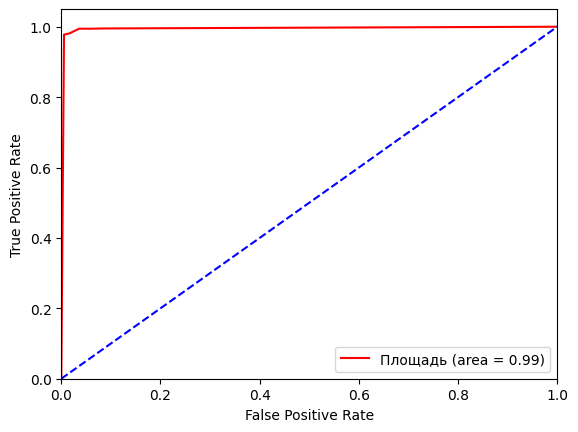

In [40]:
use_model(clone(knn), x_train, y_train, x_test, y_test)

Score on train: 0.9925311203319502
Score on test: 0.9832026875699889
Cross validation got 0.97 accuracy with a standard deviation of 0.03
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       353
           1       0.99      0.99      0.99      1433

    accuracy                           0.98      1786
   macro avg       0.97      0.98      0.97      1786
weighted avg       0.98      0.98      0.98      1786

ROC AUC=0.984


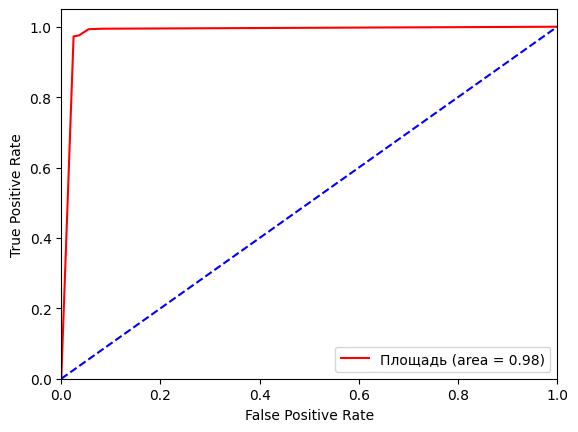

In [41]:
use_model(clone(knn), x_train_cleaned, y_train_cleaned, x_test, y_test)

### Logistic Regression

In [42]:
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')

Score on train: 0.9850634802091113
Score on test: 0.9820828667413214
Cross validation got 0.98 accuracy with a standard deviation of 0.01
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       369
           1       0.99      0.99      0.99      1417

    accuracy                           0.98      1786
   macro avg       0.98      0.97      0.97      1786
weighted avg       0.98      0.98      0.98      1786

ROC AUC=0.997


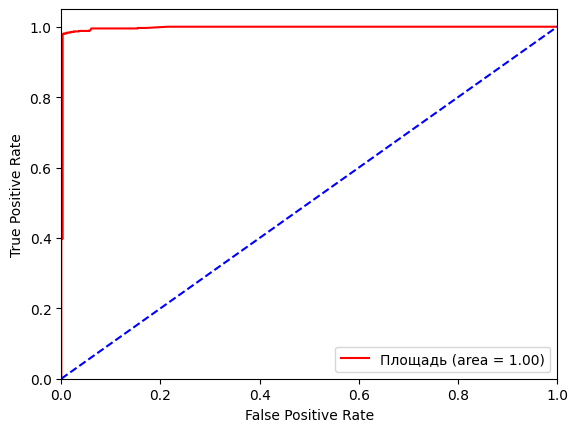

In [43]:
use_model(clone(lr), x_train, y_train, x_test, y_test)

Score on train: 0.9904564315352697
Score on test: 0.9759238521836506
Cross validation got 0.98 accuracy with a standard deviation of 0.01
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       362
           1       0.99      0.98      0.98      1424

    accuracy                           0.98      1786
   macro avg       0.96      0.96      0.96      1786
weighted avg       0.98      0.98      0.98      1786

ROC AUC=0.996


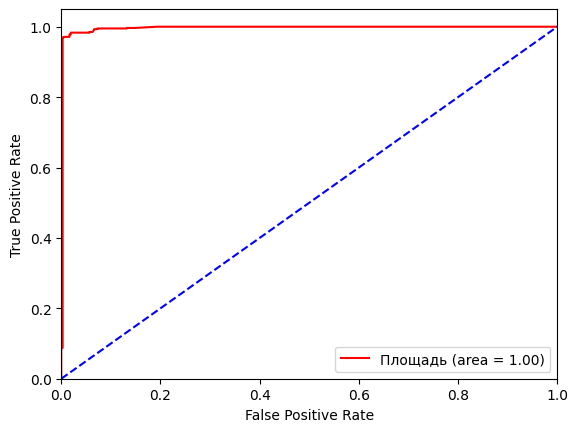

In [44]:
use_model(clone(lr), x_train_cleaned, y_train_cleaned, x_test, y_test)

### Naive Bayes

In [45]:
nb = BernoulliNB()

Score on train: 0.9667662434652726
Score on test: 0.9658454647256439
Cross validation got 0.94 accuracy with a standard deviation of 0.03
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       360
           1       0.98      0.98      0.98      1426

    accuracy                           0.97      1786
   macro avg       0.95      0.95      0.95      1786
weighted avg       0.97      0.97      0.97      1786

ROC AUC=0.990


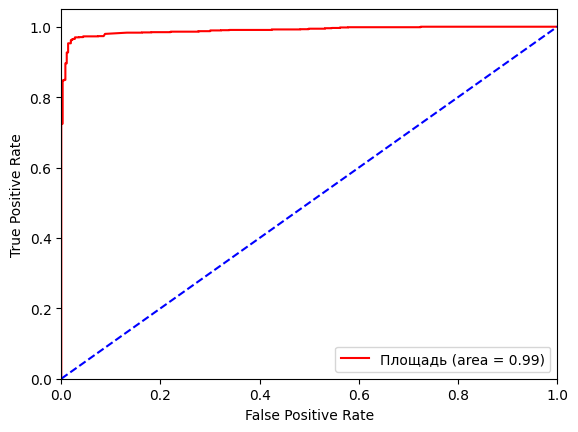

In [46]:
use_model(clone(nb), x_train, y_train, x_test, y_test)

Score on train: 0.9697095435684647
Score on test: 0.9456886898096305
Cross validation got 0.94 accuracy with a standard deviation of 0.03
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       312
           1       0.98      0.95      0.97      1474

    accuracy                           0.95      1786
   macro avg       0.89      0.94      0.91      1786
weighted avg       0.95      0.95      0.95      1786

ROC AUC=0.988


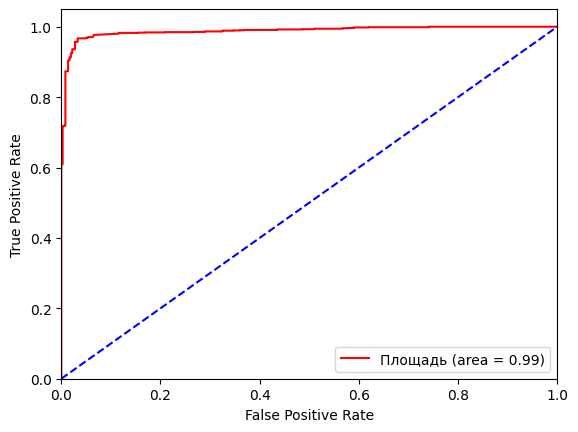

In [47]:
use_model(clone(nb), x_train_cleaned, y_train_cleaned, x_test, y_test)

### Random Forest

In [48]:
rf = RandomForestClassifier(bootstrap=True, n_estimators=4, max_features='sqrt', max_depth=5)

Score on train: 0.9712471994025392
Score on test: 0.961926091825308
Cross validation got 0.93 accuracy with a standard deviation of 0.04
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       361
           1       0.98      0.98      0.98      1425

    accuracy                           0.96      1786
   macro avg       0.94      0.94      0.94      1786
weighted avg       0.96      0.96      0.96      1786

ROC AUC=0.991


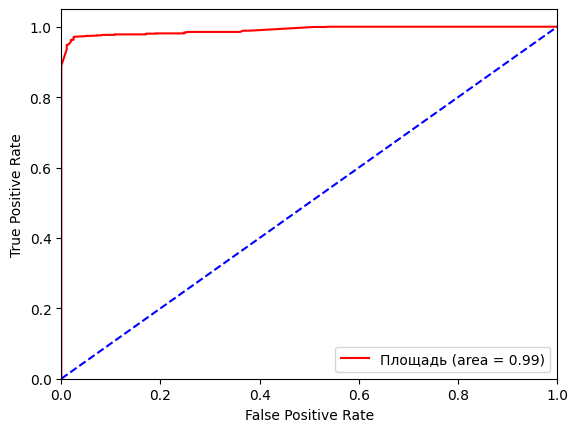

In [49]:
use_model(clone(rf), x_train, y_train, x_test, y_test)

Score on train: 0.9892116182572614
Score on test: 0.9759238521836506
Cross validation got 0.95 accuracy with a standard deviation of 0.04
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       372
           1       0.98      0.99      0.98      1414

    accuracy                           0.98      1786
   macro avg       0.97      0.96      0.96      1786
weighted avg       0.98      0.98      0.98      1786

ROC AUC=0.992


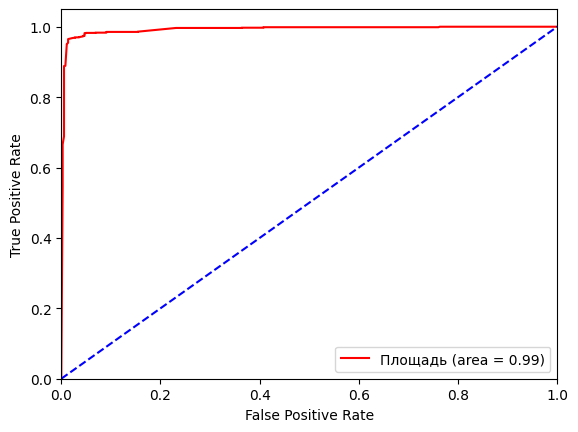

In [50]:
use_model(clone(rf), x_train_cleaned, y_train_cleaned, x_test, y_test)

### Support Vector

In [51]:
sv = SVC(kernel='linear', probability=True, class_weight='balanced')

Score on train: 0.9895444361463779
Score on test: 0.9815229563269877
Cross validation got 0.98 accuracy with a standard deviation of 0.01
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       374
           1       0.98      0.99      0.99      1412

    accuracy                           0.98      1786
   macro avg       0.98      0.97      0.97      1786
weighted avg       0.98      0.98      0.98      1786

ROC AUC=0.994


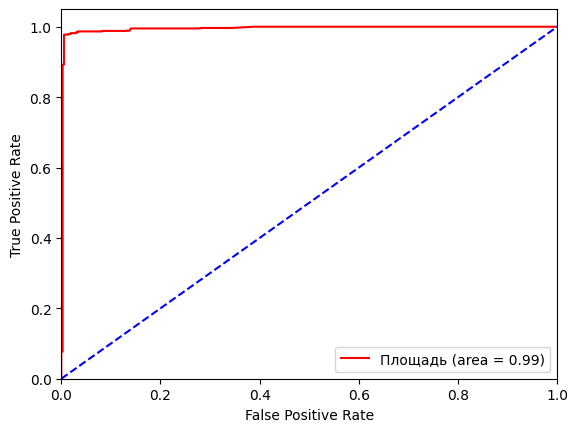

In [52]:
# https://stackoverflow.com/questions/47312432/attributeerrorlinearsvc-object-has-no-attribute-predict-proba
use_model(clone(sv), x_train, y_train, x_test, y_test)

Score on train: 0.9921161825726141
Score on test: 0.9809630459126539
Cross validation got 0.98 accuracy with a standard deviation of 0.01
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       371
           1       0.99      0.99      0.99      1415

    accuracy                           0.98      1786
   macro avg       0.97      0.97      0.97      1786
weighted avg       0.98      0.98      0.98      1786

ROC AUC=0.992


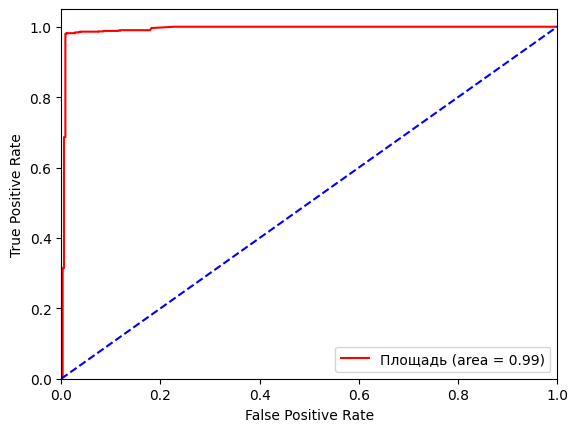

In [53]:
use_model(clone(sv), x_train_cleaned, y_train_cleaned, x_test, y_test)

### Ensamble of all models

In [54]:
#create a dictionary of our models
knn_for_ensemble = clone(knn)
knn_for_ensemble.fit(x_train, y_train)
lr_for_ensemble = clone(lr)
lr_for_ensemble.fit(x_train, y_train)
nb_for_ensemble = clone(nb)
nb_for_ensemble.fit(x_train, y_train)
rf_for_ensemble = clone(rf)
rf_for_ensemble.fit(x_train, y_train)
sv_for_ensemble = clone(sv)
sv_for_ensemble.fit(x_train, y_train)
estimators=[
    ('knn', clone(knn_for_ensemble)),
    ('lr', clone(lr_for_ensemble)),
    ('nb', clone(nb_for_ensemble)),
    ('rf', clone(rf_for_ensemble)),
    ('sv', clone(sv_for_ensemble))
]
ensemble = VotingClassifier(estimators, voting='hard')

In [55]:
# При voting = hard не получится посчитать roc auc, потому что не известны вероятности - результат выбирается голосованием моделей.
use_model(clone(ensemble), x_train, y_train, x_test, y_test, calc_roc_auc=False)

Score on train: 0.9839432412247946
Score on test: 0.9820828667413214
Cross validation got 0.97 accuracy with a standard deviation of 0.02
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       373
           1       0.99      0.99      0.99      1413

    accuracy                           0.98      1786
   macro avg       0.98      0.97      0.97      1786
weighted avg       0.98      0.98      0.98      1786



In [56]:
use_model(clone(ensemble), x_train_cleaned, y_train_cleaned, x_test, y_test, calc_roc_auc=False)

Score on train: 0.9933609958506224
Score on test: 0.9826427771556551
Cross validation got 0.98 accuracy with a standard deviation of 0.01
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       360
           1       0.99      0.99      0.99      1426

    accuracy                           0.98      1786
   macro avg       0.97      0.97      0.97      1786
weighted avg       0.98      0.98      0.98      1786



Выбор наиболее перспективной схемы

Проанализировав качество работы 5 предложенных схем, наиболее перспективной была выбрана первая,
использующая классификатор knn с параметром "количество соседей" = 5.
Эта схема показала лучшие результаты сразу по нескольким метрикам:
Самый высокий показатель на тестовых данных: 0.9871220604703248
Самый высокий показатель weighted avg recall, precition, f1-score : 0,99

Сравнение наиболее перспективной схемы и ансабля из 5ти схем

Выбранная наиболее перспективная схема показала лучшие результаты чем ансамбль из 5ти схем по всем метрикам.